In [1]:
import os
import pandas as pd
import numpy as np
import copy
import sys
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_rows', 50)
sys.path.append("/Users/peterpriestley/hmf/repos/scripts/analysisscripts") 
import chromosomeDefinition as cd
import analyseVCF as aVCF

In [2]:
CNV_COLUMNS = ['chrom','posStart','posEnd','copyNum','gainOrLoss','BAF','score','germlineOrSomatic','oneOrZero']

In [3]:
# LOAD BED
BED_PATH = "/Users/peterpriestley/hmf/analyses/slices/"
BED_PATH = "/Users/peterpriestley/hmf/analyses/giabTruthsets/"
BED_FILE_NAME = "NA12878_GIAB_highconf_IllFB-IllGATKHC-CG-Ion-Solid_ALLCHROM_v3.2.2_highconf.bed"
bed = aVCF.loadBEDFile(BED_PATH,BED_FILE_NAME)

In [4]:
# HEALTH CHECKS
HEALTH_CSV_PATH="/Users/peterpriestley/hmf/analyses/healthCheckAnalysis/"
HEALTH_CSV_FILENAME="healthCheckFile.csv"

In [6]:
#CSV_PATH="/Users/peterpriestley/hmf/analyses/PON/"
CSV_PATH = "/Users/peterpriestley/hmf/analyses/CPCT02010508/"
CSV_FILENAMES=[]
BAF_FILENAMES=[]
for x in os.listdir(CSV_PATH):
    if x[-5:] == "_CNVs":
        CSV_FILENAMES.append(x)
    if x[-8:] == "_BAF.txt":
        BAF_FILENAMES.append(x)
CSV_FILENAMES=CSV_FILENAMES[0:2]
BAF_FILENAMES=BAF_FILENAMES[0:2]
print CSV_FILENAMES,BAF_FILENAMES

['CPCT02010508T_dedup.realigned.pileup.gz_CNVs', 'CPCT02010508T_dedup.realigned.pileup.gz_normal_CNVs'] ['CPCT02010508_BAF.txt']


In [ ]:
#VCF
#VCF_PATH = "/Users/peterpriestley/hmf/analyses/ensembleRuleTesting/"
VCF_PATH = "/Users/peterpriestley/hmf/analyses/CPCT02010508/"
# BED


USE_BED = True
LOAD_FULL_FILE = True


# TEMP NA12878 VCF CONFIG
#VCF_SAMPLE = "12878"
#VCF_PATH = "/Users/peterpriestley/hmf/analyses/NA12878vsNA12878/Oct28germline/"
#VCF_FILE_NAME = "GIAB12878vGIAB12878-new3.filtered_variants.vcf"

# HEALTH CHECKS
HEALTH_CSV_PATH="/Users/peterpriestley/hmf/analyses/healthCheckAnalysis/"
HEALTH_CSV_FILENAME="healthCheckFile.csv"

In [7]:
def loadCNVforPatient(cnvFile,patientName):
    dfCNV = pd.read_table(cnvFile, names = CNV_COLUMNS )
    #add regions with default copy number
    last = dfCNV.iloc[0]
    for i in range(1, dfCNV.shape[0]-1):
        if last['posEnd']<>dfCNV.iloc[i]['posStart']:
            if last['chrom']==dfCNV.iloc[i]['chrom']:
                dfCNV.loc[len(dfCNV)] = [last['chrom'],last['posEnd'], dfCNV.iloc[i]['posStart']-1,2,'none','','',0,0]
            else:
                dfCNV.loc[len(dfCNV)] = [last['chrom'],last['posEnd'], cd.chromosomeLength[last['chrom']],2,'none','','',0,0]
                if dfCNV.iloc[i]['posStart']<>0:
                    dfCNV.loc[len(dfCNV)] = [dfCNV.iloc[i]['chrom'],0, dfCNV.iloc[i]['posStart'],2,'none','','',0,0]
        last = dfCNV.iloc[i]
    #fix first record
    if dfCNV.iloc[0]['posStart']<>0:
        dfCNV.loc[len(dfCNV)] = ['1',0, dfCNV.iloc[0]['posStart'],2,'none','','',0,0]
    #Additional Fields
    dfCNV['chromPos']= dfCNV['chrom'].apply(lambda x: cd.intChrom(x)) + dfCNV['posStart'] / dfCNV['chrom'].apply(lambda x: cd.chromosomeLength[str(x)])
    dfCNV['chrom'] = dfCNV['chrom'].apply(lambda x: cd.intChrom(x))
    dfCNV['cappedCopyNum'] = dfCNV['copyNum'].clip(upper=5)
    dfCNV = dfCNV.sort_values(["chrom","posStart","posEnd"]).reset_index()
    dfCNV['regionLength'] = (dfCNV['posEnd']-dfCNV['posStart'])
    dfCNV['patientName']=patientName
    return dfCNV

In [8]:
def calculateMBAFCountBetween(chrom,minPos,maxPos):
   return dfBAF[(dfBAF.Chromosome==chrom)&(dfBAF.Position>minPos)&(dfBAF.Position<maxPos)]['mBAF'].count()

In [9]:
def calculateMBAFBetween(chrom,minPos,maxPos):
   return dfBAF[(dfBAF.Chromosome==chrom)&(dfBAF.Position>minPos)&(dfBAF.Position<maxPos)]['mBAF'].median()

In [10]:
def findCNV(chrom,Pos):
   return dfCNV[(dfCNV.chrom==chrom)&(dfCNV.posStart<Pos)&(dfCNV.posEnd>Pos)]['copyNum']

In [11]:
def loadBAFData(bafFile):
    df = pd.read_table(bafFile)
    return df

In [12]:
def loadHealthChecksAndMerge(df):
    hc = pd.read_csv(HEALTH_CSV_PATH + HEALTH_CSV_FILENAME)
    hc = hc[['SAMPLE','TUMOR_PERCENTAGE','TUMOR_TYPE','PIPELINE_VERSION']]
    hc = hc[hc['SAMPLE'].str[12]=="T"]   # only tumor rows
    hc['SAMPLE']=hc['SAMPLE'].str[:12]
    hc = hc.set_index(['SAMPLE'])
    df = pd.merge(df,hc,how='left', left_on='patientName',right_index=True)
    df.fillna("Unknown", inplace=True)
    return df

In [13]:
def cnvChart(dfCNV,filename,minChrom=1,maxChrom=23):
    plt.figure(figsize=[18,3])
    plt.title(filename)
    ax = plt.gca()
    ax.plot(dfCNV['chromPos'], dfCNV['copyNum'],drawstyle="steps-post")
    ax.axis([minChrom, maxChrom, 0, 6])
       

In [14]:
def cnvLabel(copyNumber):
    if copyNumber < 2:
        return 'loss'
    elif copyNumber > 2:
        return 'amplification'
    else:
        return'normal'

In [15]:
def runGeneCNVAnalysis(dfCNV,bed,patientName):
    geneList =[]
    for bedrow in bed:
        bedChromPosStart = cd.intChrom(bedrow[0]) + float(bedrow[1])/cd.chromosomeLength[bedrow[0]]
        bedChromPosEnd = cd.intChrom(bedrow[0]) + float(bedrow[1])/cd.chromosomeLength[bedrow[0]]
        prevCNV = max(dfCNV[(dfCNV['chromPos'] < bedChromPosStart)].index.tolist())
        if dfCNV[(dfCNV['chromPos'] > bedChromPosEnd) ].index.tolist():
            nextCNV = min(dfCNV[(dfCNV['chromPos'] > bedChromPosEnd) ].index.tolist())
            minCopyNum = min(([dfCNV.iloc[x]['copyNum']]) for x in range (prevCNV,nextCNV)) 
        else:
            minCopyNum = [-1]
        geneList.append([patientName,bedrow[3],bedrow[0],bedrow[1],bedrow[2],minCopyNum[0],cnvLabel(minCopyNum[0])])
    return geneList

### Load BAF and CNV and calculate median BAF per segment

In [16]:
dfBAF = loadBAFData(CSV_PATH+BAF_FILENAMES[0])
dfBAF = dfBAF[['Chromosome','Position','BAF']]
dfBAF['mBAF']= 0.5+abs(dfBAF['BAF']-0.5)
dfBAF['chromPos']= dfBAF['Chromosome'].apply(lambda x: cd.intChrom(x)) + dfBAF['Position'] / dfBAF['Chromosome'].apply(lambda x: cd.chromosomeLength[str(x)])
dfBAF['Chromosome']= dfBAF['Chromosome'].apply(lambda x: cd.intChrom(x))
len(dfBAF)

69927

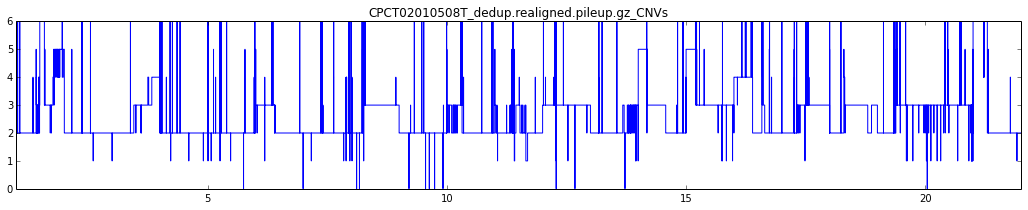

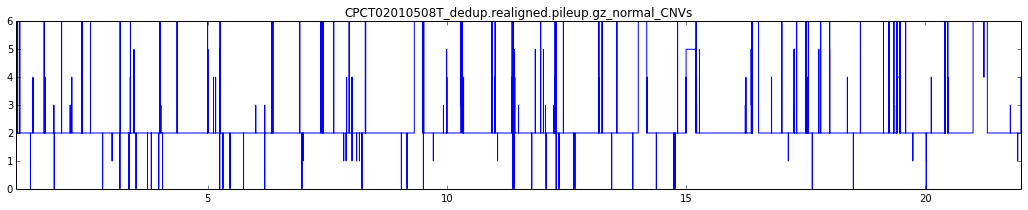

In [17]:
dfAllCNV=pd.DataFrame()
dfAllGeneCNV=pd.DataFrame()
for filename in CSV_FILENAMES:
    patientName=filename[:12]
    dfCNV = loadCNVforPatient(CSV_PATH+filename,patientName)
    dfCNV['mBAF'] = np.vectorize(calculateMBAFBetween)(dfCNV['chrom'], dfCNV['posStart'],dfCNV['posEnd'])
    dfCNV['mBAFCount'] = np.vectorize(calculateMBAFCountBetween)(dfCNV['chrom'], dfCNV['posStart'],dfCNV['posEnd'])
    cnvChart(dfCNV,filename,1,22)
    dfAllCNV=pd.concat([dfAllCNV,dfCNV])
dfAllCNV = loadHealthChecksAndMerge(dfAllCNV)

In [18]:
#dfBAF['CNV'] = np.vectorize(findCNV)(dfBAF['Chromosome'], dfBAF['Position'])

### TUMOR PURITY

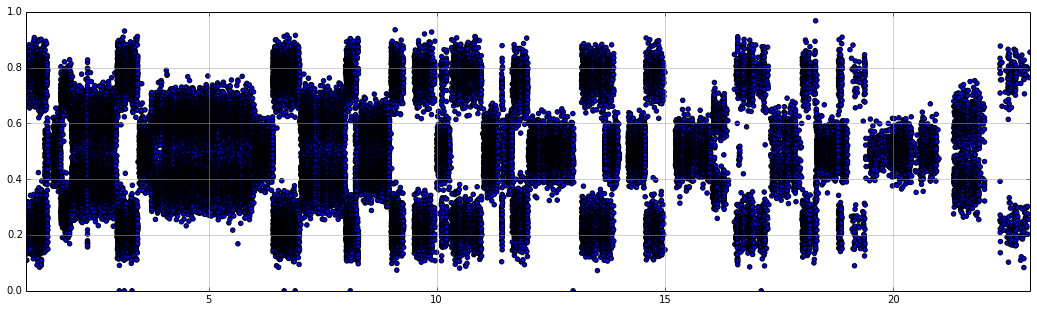

In [19]:
c = 1
fractionMin = 0
fractionMax = 22
dfSom = dfBAF[(dfBAF.chromPos>c+fractionMin)&(dfBAF.chromPos<c+fractionMax)]
plt.figure(figsize=[18,5])
plt.scatter(dfSom.chromPos, dfSom.BAF)
plt.grid(b=True, which='both', color='0.65',linestyle='-')
plt.axis([c+fractionMin, c+fractionMax,0, 1.0])
plt.show()

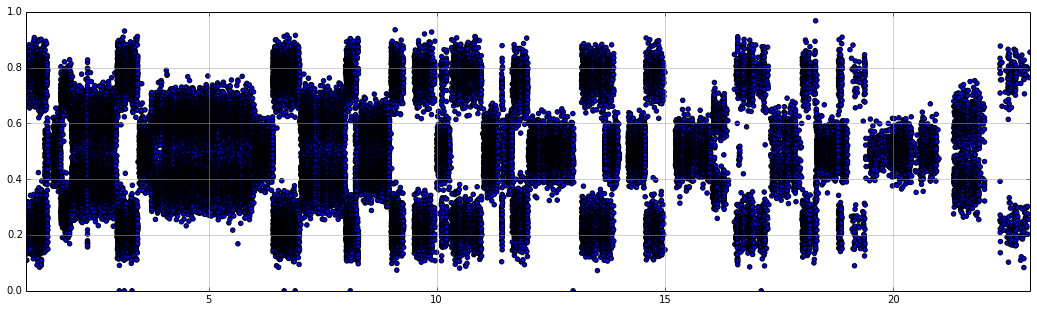

In [20]:
c = 1
fractionMin = 0
fractionMax = 22
dfSom = dfBAF[(dfBAF.chromPos>c+fractionMin)&(dfBAF.chromPos<c+fractionMax)]
plt.figure(figsize=[18,5])
plt.scatter(dfSom.chromPos, dfSom.BAF)
plt.grid(b=True, which='both', color='0.65',linestyle='-')
plt.axis([c+fractionMin, c+fractionMax,0, 1.0])
plt.show()

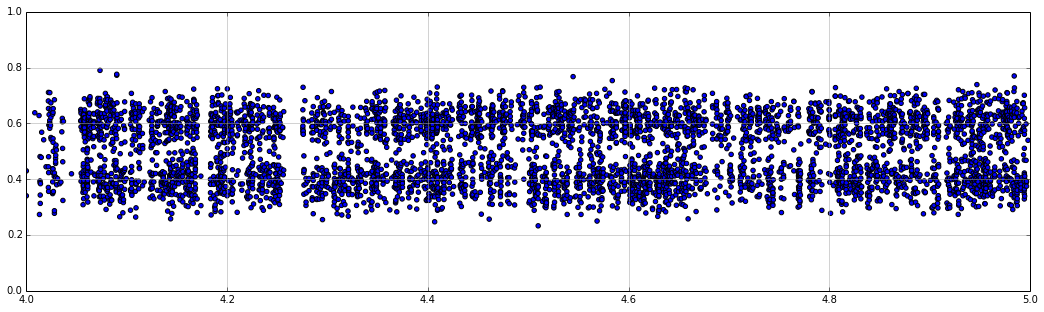

In [41]:
c = 4
fractionMin = 0.0
fractionMax = 1.0
dfSom = dfBAF[(dfBAF.chromPos>c+fractionMin)&(dfBAF.chromPos<c+fractionMax)]
plt.figure(figsize=[18,5])
plt.scatter(dfSom.chromPos, dfSom.BAF)
plt.grid(b=True, which='both', color='0.65',linestyle='-')
plt.axis([c+fractionMin, c+fractionMax,0, 1.0])
plt.show()

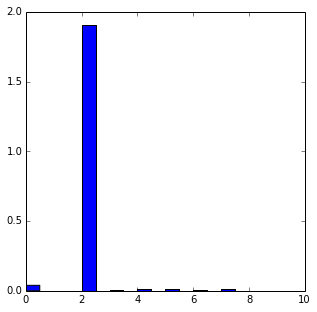

In [21]:
#IMPORTANT - make sure we use mBAFCount for weight!!!
# probably need 2% to be CNV = 1 or 3?
plt.figure(figsize=[5,5])
plt.hist(dfCNV['copyNum'].values,cumulative=False, normed=True, bins=20,range=(0,10),weights=dfCNV['regionLength'].values)
plt.show()

In [36]:
#pd.pivot_table(dfCNV[dfCNV.copyNum<>-1], values='mBAFCount', index=['chrom'], columns=['cappedCopyNum'], aggfunc='sum',margins=True).fillna(0).sort_values("All",ascending=False)

/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/matplotlib/axes.py:8261: UserWarning: 2D hist input should be nsamples x nvariables;
 this looks transposed (shape is 0 x 1)
  'this looks transposed (shape is %d x %d)' % x.shape[::-1])


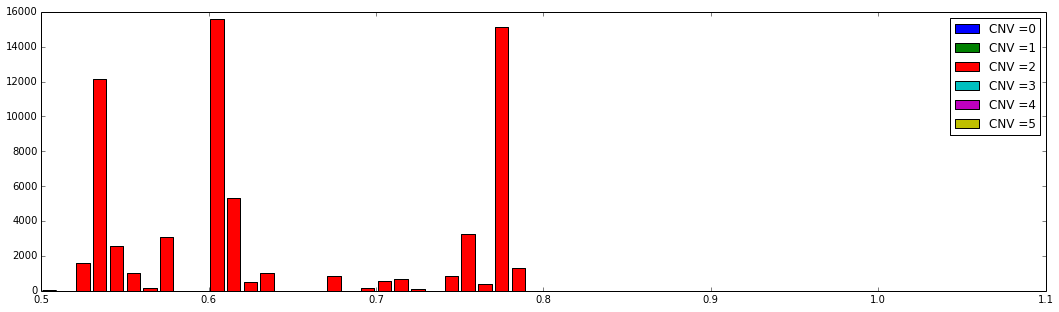

In [23]:
# should only use regions with mbaf > x
fractionMin = 0
fractionMax = 23
dftemp = dfCNV[(dfCNV.mBAF>=0.0)&(dfCNV.mBAF<=1.0)&(dfCNV.mBAFCount>100)&(dfCNV.chromPos<=fractionMax)&(dfCNV.chromPos>=fractionMin)]
plt.figure(figsize=[18,5])
for CNV in range(0,6):
    plt.hist(dftemp[(dftemp.copyNum==CNV)]['mBAF'].values,cumulative=False, normed=False, bins=50,range=(0.5,1.0),weights=dftemp[(dftemp.copyNum==CNV)]['mBAFCount'].values,stacked = True,rwidth=0.8,label='CNV ='+str(CNV))
    plt.legend()
plt.show()

In [42]:
dfCNV[(dfCNV.chrom==c)&(dfCNV.mBAFCount>100)][['chrom','posStart','copyNum','chromPos','regionLength','mBAF','mBAFCount']]

,chrom,posStart,copyNum,chromPos,regionLength,mBAF,mBAFCount
89,4,10235000,2,4.053543,58028999,0.607143,1610
91,4,68267000,2,4.357130,121929999,0.606838,3505


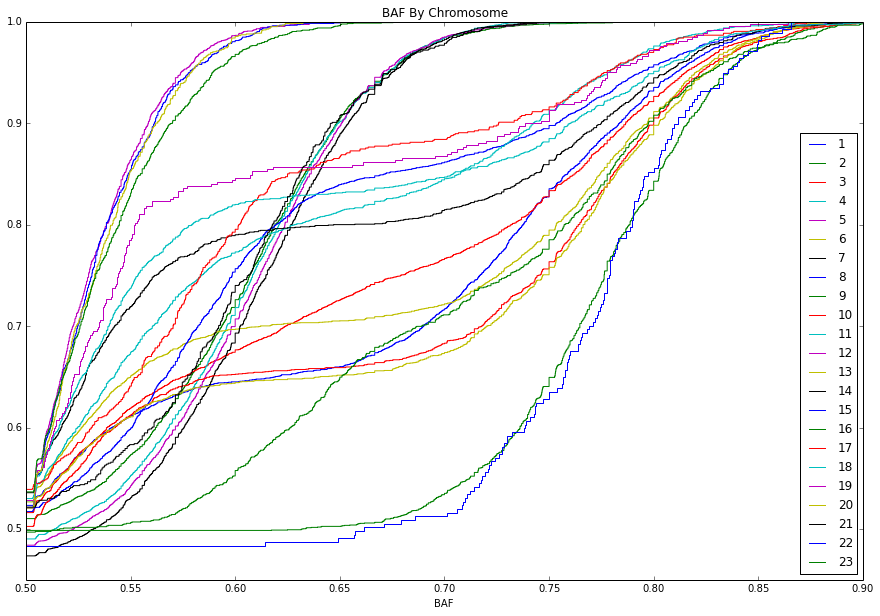

In [28]:
chromosomes = dfBAF['Chromosome'].unique()
for chromosome in chromosomes:
    ser = dfBAF[dfBAF.Chromosome==chromosome]["BAF"]
    ser = ser.sort_values()
    cum_dist = np.linspace(0.,1.,len(ser))
    ser_cdf = pd.Series(cum_dist, index=ser,name=str(chromosome))
    ser_cdf.plot(drawstyle='steps',legend=True,title="BAF By Chromosome",figsize=[15,10],xlim=[0.5,0.9],ylim=[0.45,1.0])